# Redes neuronales de larga y corta memoria (LSTM) aplicadas a la predicción de volatilidad en el stock del S&P500

En la actualidad, el mercado de acciones es una industria en constante evolución y con una gran cantidad de información disponible. La capacidad de predecir la volatilidad en el stock de una empresa puede ser de gran utilidad para los inversionistas y traders. Por lo tanto, en este trabajo exploraré cómo las redes neuronales de larga y corta memoria (LSTM) pueden ser aplicadas para predecir la volatilidad un stock.

Este tipo de redes tienen algunas cosas especiales que han de hacerse con los datos... Sin embargo, todo esto y más se explicará paso por paso en la realización del código.

***

In [1]:
#Paquetes para tratamiento de datos
import pandas as pd
import numpy as np

#Paquetes para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Quitar warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_context("paper")
plt.rc("font", size=14)

***
Los datos se han conseguido con ayuda de la plataforma de **Dukascopy Bank**. Esta es una banca online suiza con sede en Ginebra que ofrece servicios de trading en línea y móvil centrados en divisas, metales preciosos, CFD y opciones binarias, así como servicios bancarios y financieros a través de soluciones tecnológicas propietarias. La empresa fue fundada el 2 de noviembre de 2004 en Ginebra por Andre y Veronika Duka, ciudadanos suizos residentes en Ginebra que todavía poseen el 99% de la empresa.

Dukascopy Bank está regulada como banco y firma de valores por la Autoridad de Supervisión del Mercado Financiero Suizo FINMA. La empresa posee completamente Dukascopy Europe IBS AS, una empresa de corretaje con licencia europea con sede en Riga y Dukascopy Japan, un corredor con licencia Tipo-1 ubicado en Tokio. Además de su sede en Ginebra, tiene oficinas en Dubai, Riga y Hong Kong. Actualmente, el Grupo Dukascopy emplea a más de 300 personas.

En este caso se descargaron los datos del *S&P500* durante el periodo de $01/03/2013$ hasta $26/02/2023$. Además, se dispone de información del precio de la acción a nivel de minuto a minuto ($1003654$ observaciones), lo que puede ser muy útil. Sin embargo, algunos datos están mal reportados o sencillamente contienen mucho ruido, por lo que es necesario realizar una limpieza previa de estos. Para calcular la volatilidad se ve conveniente agrupar los datos en rangos de $5$ minutos para evitar ruido innecesario. Se dispone de un total de $215645$ rangos de precios. 

Referencia: 
- [Dukascopy Bank](https://www.dukascopy.com/swiss/spanish/about/company/)

***

In [2]:
prices_ask = pd.read_csv(r"C:~\Data\USA500IDXUSD_1 Min_Bid_2011.09.19_2023.02.26.csv", sep = ",")
prices_ask["Time (EET)"] = pd.to_datetime(prices_ask["Time (EET)"], format='%Y.%m.%d %H:%M:%S.%f')
prices_ask.set_index("Time (EET)", inplace=True)
prices_ask = prices_ask.between_time('16:30', '23:00')
prices_ask = prices_ask.loc['2013-03-01':]
prices_ask = prices_ask.dropna()

prices_5min_close = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Close"].last()
prices_5min_open = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Open"].first()
prices_5min_high = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["High"].max()
prices_5min_low = prices_ask.groupby([pd.Grouper(level =0, freq='5Min')])["Low"].min()

prices = pd.merge(prices_5min_open,prices_5min_close, how='inner', left_index=True, right_index=True)
prices = pd.merge(prices,prices_5min_high, how='inner', left_index=True, right_index=True)
prices = pd.merge(prices,prices_5min_low, how='inner', left_index=True, right_index=True)
prices = prices.dropna()

display(prices.head())
print("Cantidad de datos: ", len(prices))

,Open,Close,High,Low
Time (EET),,,,
2013-03-01 16:30:00,1513.131,1513.301,1513.355,1513.102
2013-03-01 16:35:00,1513.336,1513.103,1513.337,1513.098
2013-03-01 16:40:00,1513.226,1513.152,1513.348,1513.103
2013-03-01 16:45:00,1513.249,1513.267,1513.337,1513.142
2013-03-01 16:50:00,1513.124,1503.929,1513.359,1503.599


Cantidad de datos:  202653


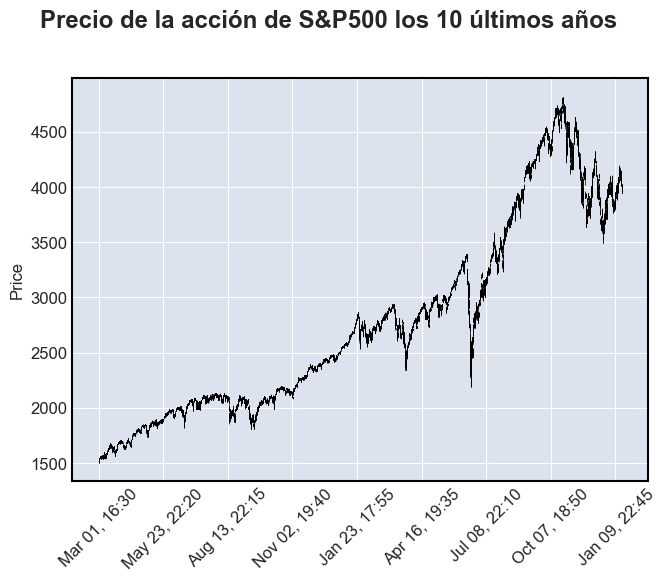

In [4]:
#Gráfico de precios en el último año
import mplfinance as mpf

mpf.plot(prices, type='candle', title = 'Precio de la acción de S&P500 los 10 últimos años',tight_layout = False, volume = False)

***

## Volatilidad Realizada (RV)

La Realized Volatility (RV) es una medida de la volatilidad financiera que se basa en la información histórica de los precios de los activos financieros y que puede ser calculada a partir de la alta frecuencia de datos de precios. A diferencia de la volatilidad implícita, que se calcula a partir de los precios de los derivados financieros, la RV se basa en datos de precios reales de los activos subyacentes.

La RV es una medida de la volatilidad más precisa que otros indicadores tradicionales, como la volatilidad histórica, debido a que se basa en una gran cantidad de datos y proporciona una imagen más completa de la volatilidad del mercado. Además, la RV tiene la ventaja de que puede ser utilizada para pronosticar la volatilidad futura.

Para calcular la RV, es necesario utilizar los datos de precios de los activos financieros en alta frecuencia, lo que implica utilizar precios de cotización que se actualizan a intervalos muy cortos de tiempo, por ejemplo, cada 5 o 15 minutos como se sugiere en Torben G Andersen et al. (2001) [1] . A partir de estos datos, se pueden calcular los retornos diarios, que representan la variación del precio de un activo financiero en un día determinado. Luego, se calcula la varianza de los retornos diarios y se obtiene la RV a partir de la raíz de la suma de los logaritmos de los retornos al cuadrado. Por conveniencia y propiedades de la distribución se realiza una transformación logarítmica del valor para que tenga una distribución semejante a la normal.

> Realised Volatilty:
 $$ RV_t = \log\sqrt{\sum_{i=1}^{N}{r_{i,t}^2}} $$
 
Referencia: [Realized Volatility Forecasting with Neural Networks](https://academic.oup.com/jfec/article/18/3/502/5856840)

La RV se ha utilizado ampliamente en la predicción de la volatilidad financiera, especialmente en combinación con modelos de redes neuronales, debido a que proporciona una medida precisa de la volatilidad del mercado y permite una mejor estimación de los parámetros de los modelos de predicción.

Referencia: [Torben G Andersen, Tim Bollerslev, Francis X Diebold & Paul Labys (2001) The Distribution of Realized Exchange Rate Volatility, Journal of the American Statistical Association, 96:453, 42-55, DOI: 10.1198/016214501750332965](https://www.tandfonline.com/doi/abs/10.1198/016214501750332965)

***

In [3]:
#Calcular los retornos
#returns = (prices['Close'] - prices['Open'])/prices['Open']
returns = np.log(prices['Close']/prices['Close'].shift()).dropna()
returns = returns[returns != 0]
display(returns.head())
print("Cantidad de días: ", len(returns))

Time (EET)
2013-03-01 16:35:00   -0.000131
2013-03-01 16:40:00    0.000032
2013-03-01 16:45:00    0.000076
2013-03-01 16:50:00   -0.006190
2013-03-01 16:55:00    0.000730
Name: Close, dtype: float64

Cantidad de días:  192993


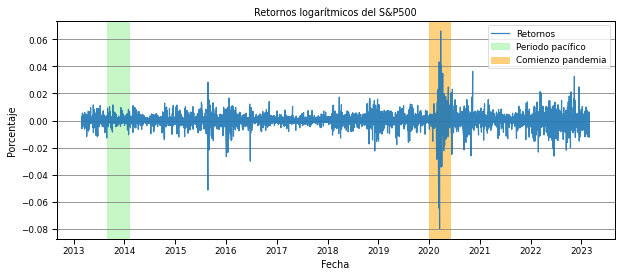

In [39]:
from datetime import datetime
from matplotlib.dates import date2num
sns.set_context("paper")

fig, ax = plt.subplots(figsize = (10,4))
plt.plot(returns, alpha = 0.9, label = "Retornos")
ax.axvspan(date2num(datetime(2013,9,1)), date2num(datetime(2014,2,1)), color='lightgreen', alpha=0.5, zorder=0, label='Periodo pacífico')
ax.axvspan(date2num(datetime(2020,1,1)), date2num(datetime(2020,6,1)), color='orange', alpha=0.5, zorder=0, label='Comienzo pandemia')
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Porcentaje")
plt.grid(axis = "y", color = "0.5")
plt.title("Retornos logarítmicos del S&P500")
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

#Check Stationarity
res_diff =  adfuller(returns)
print(f'ADF Test p-value: {res_diff[1]}')
#If p-value below 0.05 means, that the returns are stationary 

ADF Test p-value: 0.0


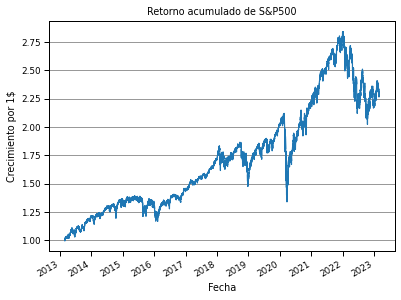

In [6]:
sns.set_context("paper")

fig = plt.figure()
cum_returns = (1 + returns ).cumprod()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
cum_returns.plot()
ax1.set_xlabel("Fecha")
plt.grid(axis = "y", color = "0.5")
ax1.set_ylabel("Crecimiento por 1$")
ax1.set_title("Retorno acumulado de S&P500")
plt.show()

***

A partir de los retornos anteriores, se ha calculado la la volatilidad realizada. Como se ha explicado anteriormente, se basa en la suma al cuadrado durante periodos de tiempo, por lo que reduce la muestra considerablemente. A partir de ahora se trabajará con una muestra de $2582$ observaciones, una por cada día de tradeo durante el periodo de $2013$ hasta $2023$ (quitando festivos y fines de semana).

***

In [4]:
returns_sq = pd.DataFrame(returns**2)
returns_sq['date'] = returns_sq.index

real_vol = np.log(np.sqrt(returns_sq.groupby([pd.Grouper(key='date', freq='d')])["Close"].sum()))

real_vol = real_vol[real_vol > -50] #Quitar valores -inf

display(real_vol.head())
print("Cantidad de datos: ", len(real_vol))

date
2013-03-01   -4.688677
2013-03-04   -5.206986
2013-03-05   -4.946116
2013-03-06   -5.350190
2013-03-07   -5.677612
Name: Close, dtype: float64

Cantidad de datos:  2582


***

A continuación podemos observar la distribución de los datos reales y la distribución del logaritmo natural de los datos. Como es natural, la volatilidad no se distribuye de forma normal, por lo que es conveniente realizar una tranformación de los datos para que se ajusten a ello. Además, las redes neuronales necesitan que los datos tengan una distribución normal. Por lo tanto trabajaremos a partir de ahora con el $log(RV)$.

Además, se observa que la distribución no es del todo simétrica sino muestra signos de *skewness* positiva, sería necesario realizar un test de normalidad para estar seguros de esta característica. Sin embargo, se continuará bajo el anterior supuesto por conveniencia.

***

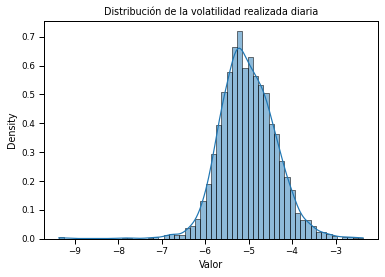

In [40]:
sns.set_context("paper")
sns.histplot(data=real_vol, kde=True, stat='density')
plt.title("Distribución de la volatilidad realizada diaria")
#plt.grid(axis = "y", color = "0.5")
plt.xlabel("Valor")

plt.show()

In [9]:
from statsmodels.stats.diagnostic import lilliefors

lilliefors(real_vol, dist='norm', pvalmethod='approx')

(0.028621260703836637, 4.4634762326412756e-05)

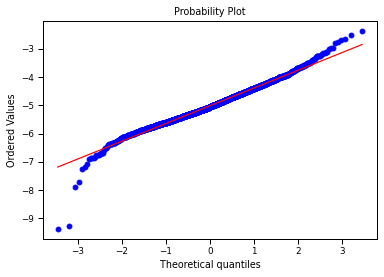

In [10]:
import pylab 
import scipy.stats as stats
# QQ Plot of the RV values
stats.probplot(real_vol, dist="norm", plot=pylab)
pylab.show()

***

Se ha querido verificar si algunos acontecimientos importantes a nivel global han tenido repercusión en la volatilidad del precio de la acción de Amazon. El asalto al capitolio no parece que haya repercutido en gran medida. Sin embargo, se puede verificar que algunos acontecimientos como las elecciones y la guerra entre Rusia y Ucrania provocaron *spikes* de volatilidad en periodos posteriores.

***

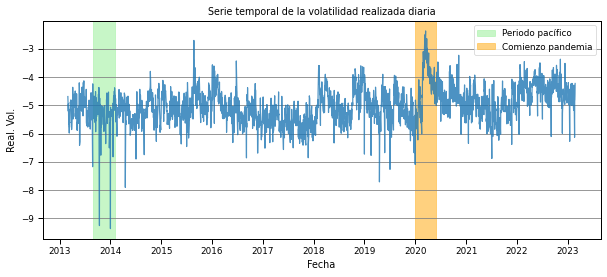

In [41]:
from datetime import datetime
from matplotlib.dates import date2num
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))
sns.lineplot(data=real_vol, alpha = 0.8)
ax.axvspan(date2num(datetime(2013,9,1)), date2num(datetime(2014,2,1)), color='lightgreen', alpha=0.5, zorder=0, label='Periodo pacífico')
ax.axvspan(date2num(datetime(2020,1,1)), date2num(datetime(2020,6,1)), color='orange', alpha=0.5, zorder=0, label='Comienzo pandemia')
plt.legend()
plt.title("Serie temporal de la volatilidad realizada diaria")
plt.ylabel("Real. Vol.")
plt.grid(axis = "y", color = "0.5")
plt.xlabel("Fecha")

plt.show()

***

Se pretende crear un algoritmo basado en redes neuronales sin variables exógenas, por lo que es necesario estudiar el factor de autocorrelación y autocorrelación parcial de la serie temporal. Los retornos de una acción suelen valores de autocorrelaciones muy bajos. Sin embargo, esto no ocurre con la volatilidad realizada. 

Como se puede observar en ambos gráficos, los valores de correlación superan con creces los valores "límite". El gráfico de autocorrelación muestra como incluso los valores anteriores de $30$ días tienen correlación con el valor en el tiempo **T**.

***

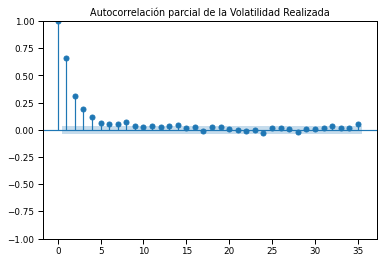

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#With PACF see possible spikes: AR 
plot_pacf(real_vol)
plt.title("Autocorrelación parcial de la Volatilidad Realizada")
plt.show()

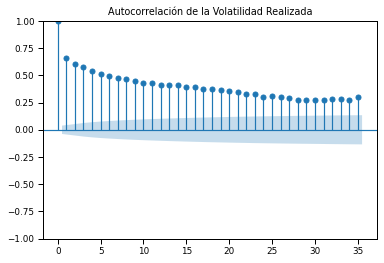

In [13]:
sns.set_context("paper")
#With ACF see possible spikes: MA
plot_acf(real_vol)
plt.title("Autocorrelación de la Volatilidad Realizada")
plt.show()

***

Aquí se separará el dataset en entrenamiento ($70$%), validación ($15$%) y test ($15$%). Además, se utilizará el estandarizador llamado **MinMaxScaler** del paquete **sklearn** (scikit-learn) para estandarizar los datos entre los valores $0$ y $1$, cosa que será muy útil para el modelo más adelante. 

> **MinMaxScaler:**
    $$ std(X) = {(X - X.min) \over (X.max - X.min)} $$
    $$ X.scaled = {std(X) * (max - min) + min} $$
    
Referencia: [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Se pretende asumir que la muestra de test es totalmente desconocida para el modelo. Por lo tanto el **MinMaxScaler** solamente será entrenado con los datos de entrenamiento y validación. Como se puede observar, las distribuciones de los datos son muy diferentes para las $3$ muestras. Esto nos indica que la volatilidad realizada ha sido especialmente alta en el último periodo. En un caso normal esto no sería beneficioso para el modelo. Sin embargo, en este estudio se pretende estudiar los rendimientos de los diferentes modelos incluso teniendo tales condiciones (que se acercan más a la realidad).

Como hipótesis se presupone que el algorítmo de reeds recurrentes LSTM sin variables exógenas tendrá resultados resultados pobres en comparación con los modelos tradicionales GARCH. Esto se cree que se aminorará en cuanto se añadan variables externas al modelo, lo que aprovecharía la ventaja de estos modelos frente a lso tradicionales autoregresivos lineales.
***

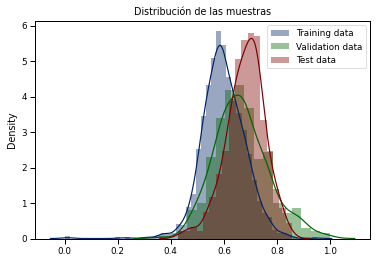

In [5]:
from sklearn.preprocessing import MinMaxScaler

n = len(real_vol)

data = np.array(real_vol).reshape(-1,1)

train = data[0:int(n*0.7)]
val = data[int(n*0.7):int(n*0.85)]
train_val = data[0:int(n*0.85)]
test = data[int(n*0.85):] #Reservar muestra desconocida

scaler = MinMaxScaler()
scaler.fit(train_val)

mean = np.mean(train)
cuasi_std = np.std(train, ddof = 1)


train = scaler.transform(train)
data = scaler.transform(data)
val = scaler.transform(val)
train_val = scaler.transform(train_val)
test = scaler.transform(test)

#train = (train - mean)/cuasi_std
#val = (val - mean)/cuasi_std
#test = (test - mean)/cuasi_std

sns.set_context("paper")
sns.distplot(train, label = "Training data", color = "#002366")
sns.distplot(val, kde=True, color = "darkgreen", label = "Validation data")
sns.distplot(test, kde=True, label = "Test data", color = "maroon",)

plt.title("Distribución de las muestras")
plt.legend()
plt.show()

In [49]:
from scipy.stats import skew

print("Muestra de entrenamiento")
print("Media: ", np.mean(train))
print("Varianza: ", np.std(train, ddof = 1))
print("Skewness: ", skew(train))
print("#####################")
print("Muestra de validación")
print("Media: ", np.mean(val))
print("Varianza: ", np.std(val, ddof = 1))
print("Skewness: ", skew(val))
print("#####################")
print("Muestra de test")
print("Media: ", np.mean(test))
print("Varianza: ", np.std(test, ddof = 1))
print("Skewness: ", skew(test))

Muestra de entrenamiento
Media:  0.5990734244940579
Varianza:  0.0811703405565449
Skewness:  [-0.39287605]
#####################
Muestra de validación
Media:  0.6657006863761229
Varianza:  0.10237353681355443
Skewness:  [0.42212196]
#####################
Muestra de test
Media:  0.6808404350112837
Varianza:  0.07290811688175974
Skewness:  [-0.48348468]


***

Los algoritmos de redes neuronales en general hacen uso de una gran variedad de hiperparámetros, lo que les permite ser muy flexibles en problemas de alta complejidad. Algunos de estos hiperparámetros son:

- Los inicializadores de pesos
- Ratio de aprendizaje (Learning rate)
- Número de capas ocultas
- Tipo de funciones de activación
- Ratio de abandono (dropout)

Además, los algoritmos de redes recurrentes son sensibles a la cantidad de observaciones con retraso (*lags*), por lo que es necesario realizar un tuneado previo para escoger el número óptimo de estas. El algoritmo *walk-forward* es una técnica de selección de modelos que combina la búsqueda en rejilla y la validación cruzada mediante una técnica de caminata hacia adelante. Este algoritmo es utilizado en el contexto de la predicción de series temporales para encontrar el modelo más adecuado a partir de una lista predefinida de modelos.

La técnica de caminata hacia adelante implica la división del conjunto de datos en ventanas de entrenamiento y validación, de forma que se utiliza una ventana de entrenamiento para ajustar el modelo y una ventana de validación para evaluar su rendimiento. Esta técnica es muy útil en la predicción de series temporales, ya que permite una evaluación más realista del rendimiento del modelo, ya que los datos futuros no están disponibles en el momento del ajuste.

La búsqueda en rejilla implica la definición de una lista predefinida de modelos con diferentes combinaciones de hiperparámetros. El algoritmo ajusta cada modelo en la lista utilizando la técnica de caminata hacia adelante y evalúa su rendimiento. El modelo que proporciona el mejor rendimiento en la validación cruzada se selecciona como el modelo final. Se realizará un *walkforward grid search* con $3$ separaciones diferentes ($30$%, $60$% y $90$% de la muestra de entrenamiento) y se promediará el error *out-of-bag* para escoger el **N** óptimo.

Finalmente, el algoritmo de redes que consigue el mejor rendimiento es aquel que dispone de la información de los anteriores $125$ días de volatilidad. Es una cantidad muy razonable para este tipo de algorítmos, debido a que puede conseguir buenos resultados de hasta $400$ observaciones anteriores. Sin embargo, es mejor quedarse con la menor cantidad de información posible para cada iteración, ya que añadir demasiada podría resultar en ruido innecesario.

***

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


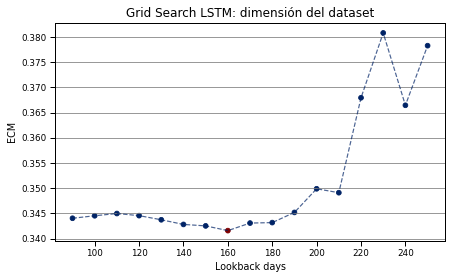

La configuración óptima es:  [160]


In [12]:
def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)

past_size = range(90,260,10)


n = len(train)
score_grid = []
cvset = [0.5, 0.85]

'''
for val in past_size : 
    score = 0
    print(val)
    for cv in cvset : 
        tf.keras.utils.set_random_seed(123)
        
        tf.random.set_seed(2)  
        np.random.seed(2)
        
        data_temp = train[0:int(n*(cv+0.15))]
        Xt_data, yt_data = create_dataset(data_temp, val)
        
        Xt_val = Xt_data[-int(n*(cv+0.15)):-int(n*cv),:]
        yt_val = yt_data[-int(n*(cv+0.15)):-int(n*cv)]
        
        train_temp = train[0:int(n*cv)]
        Xt_train, yt_train = create_dataset(train_temp, val)
        

        Xt_train = Xt_train.reshape(Xt_train.shape[0],Xt_train.shape[1] , 1)
        Xt_val = Xt_val.reshape(Xt_val.shape[0],Xt_val.shape[1] , 1)

        mod_temp = Sequential()
        mod_temp.add(LSTM(128,activation="tanh", input_shape=(Xt_train.shape[1], Xt_train.shape[2])))
        mod_temp.add(Dense(1, activation = "relu"))

        mod_temp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tf.keras.metrics.MeanSquaredError())

        mod_temp.fit(
                Xt_train,
                yt_train,
                epochs = 5,
                validation_data=(Xt_val, yt_val),
                batch_size=16,
                verbose = 0)
        score_temp = mod_temp.evaluate(Xt_val, yt_val, batch_size=16, verbose = 0)
        score += float(score_temp[0])
    score_grid.append(round(score/len(cvset),6))
'''
score_grid = [0.344034,
 0.34453,
 0.344974,
 0.344554,
 0.343734,
 0.342811,
 0.342522,
 0.341583,
 0.34308,
 0.343174,
 0.345191,
 0.349884,
 0.349106,
 0.367938,
 0.380801,
 0.366448,
 0.378277]


zmin = np.min(score_grid)
mask = np.array(score_grid) == zmin
color = np.where(mask, 'maroon', '#002366')

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (7,4))
plt.scatter(x = past_size, y = score_grid, color=color, alpha = 1)
plt.plot(past_size, score_grid, alpha = 0.7, color = '#002366', linestyle = "--")
plt.ticklabel_format(useOffset=False) 

plt.title("Grid Search LSTM: dimensión del dataset", fontsize = 12)
plt.ylabel("ECM")
plt.xlabel("Lookback days")
plt.grid(axis = "y", color = "0.5")
plt.show()
print("La configuración óptima es: ", np.array(past_size)[np.array(score_grid) == zmin])

***

Las redes de larga y corta memoria necesitan que sus datos de entrada estén en $3$ dimensiones. La primera es la cantidad de samples de la muestra, la segunda es la longitud de pasos en cada sample y la última sería la cantidad de covariables del modelo (en este caso $1$). Este tipo de redes neuronales no funciona demasiado bien si cada sample tiene más de $400$ observaciones, por lo que es necesario hacer la siguiente transformación:

> Supongamos que tenemos la siguiente serie temporal $[1,2,3,4,5,6,7,8,9]$. En el caso de que queramos hacer samples de $2$ observaciones, nuestro dataset quedaría de la siguiente manera:
$$[1,2],[2,3],[3,4]...$$
> En este caso tendíamos un total de $9$ samples con $2$ observaciones cada una.

Para predecir cada día de volatilidad cogeremos los datos de las $25$ semanas anteriores ($125$ días de cotización) y haremos samples de la forma que se especificó anteriormente. Así crearemos un dataset de $3$ dimensiones que nuestro modelo de LSTM sea capaz de entender.

***

In [9]:
#Crear los datasets con óptima configuración

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 160

X_train, y_train = create_dataset(train, time_step)
X_data, y_data = create_dataset(data, time_step)

ntest = int(len(X_data)*0.15)

X_test = X_data[-ntest:,:]
y_test = y_data[-ntest:]

X_val = X_data[-(ntest*2):-ntest,:]
y_val = y_data[-(ntest*2):-ntest]

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

***

*Keras Tuner* es una biblioteca de *Python* de búsqueda de hiperparámetros para el framework de deep learning Keras, que permite optimizar los hiperparámetros de los modelos de redes neuronales para obtener un mejor rendimiento. En particular, proporciona una interfaz sencilla para definir espacios de hiperparámetros y ejecutar una búsqueda en dichos espacios para encontrar la mejor combinación de hiperparámetros. Sencillamente es necesario especificar un rango de valores bajo el prefijo de *hp* para que la función realice la optimización de hiperparámetros. 

En este caso se han especificado los siguientes valores e intervalos para el tuneado de hiperparámetros:
- Función de activación oculta: *ReLu, Swish, Sigmoid, Tanh, Elu y lineal*
- Función de activación de salida: *ReLu, Swish, Elu y lineal*
- Unidades de capas ocultas: $16-512$ con pasos de $16$
- Ratio de abandono: $0-0.2$ con pasos de $0.05$
- Ratio de abandono recurrente: $0-0.2$ con pasos de $0.05$
- Ratio de aprendizaje: $0.0001-0.01$ con muestreo en escala *log*

Después de definir el modelo es necesario compilarlo y especificar sus métricas y optimizadores. En este caso se utilizará uno de los optimizadores más populares en el Deep Learning llamado *Adam*. Adam es una combinación de los optimizadores de gradiente descendente estocástico y RProp. Fue presentado por Diederik Kingma y Jimmy Ba en el paper "Adam: A Method for Stochastic Optimization" en 2014.

Adam funciona manteniendo una media y varianza móviles de los gradientes, y utiliza estos valores para actualizar los pesos en lugar de simplemente utilizar el gradiente actual. Esto permite a Adam adaptarse automáticamente a diferentes escalas y direcciones de los gradientes, lo que resulta en una convergencia más rápida y estable en comparación con otros optimizadores como SGD.

Además, Adam también incluye una técnica de ajuste de aprendizaje, que permite controlar la velocidad a la que se actualizan los pesos. Esto es útil cuando los gradientes son muy altos o muy bajos, lo que podría hacer que el optimizador se desvíe o se detenga prematuramente. En resumen, Adam es un optimizador eficiente y altamente recomendado para el entrenamiento de modelos de aprendizaje profundo. Y es fácil de implementar en librerías como *Keras*, simplemente especificando *'adam'* como el optimizador a utilizar durante el entrenamiento del modelo. 

Además, las métricas a utilizar en el entrenamiento y evaluación es el error cuadrático medio. Esto es debido a que la distribución de los valores parecen tener una distribución simétrica y se asumirá que pertenece a la familia de las exponenciales.


Tras determinar los espacios de búsqueda y las métricas de compilación del modelo es necesario especificar la *"estrategia"* de búsqueda. Keras Tuner ofrece varias diferentes, pero en este caso se utilizará la búsqueda de *Hyperband*. Este es un algoritmo de búsqueda de hiperparámetros que se basa en la eliminación temprana (early-stopping) para acelerar el proceso de tuneado. La eliminación temprana implica interrumpir el entrenamiento de un modelo si su rendimiento no mejora después de cierto número de épocas. *Hyperband* aprovecha esta técnica para explorar de forma eficiente una amplia gama de hiperparámetros en un tiempo razonable. Es especialmente útil para la búsqueda de hiperparámetros en modelos de deep learning, ya que estos modelos suelen requerir un entrenamiento intensivo y costoso en términos de tiempo y recursos computacionales.

***

***

**TEXTO PROVISIONAL:** aquí se pretende añadir todas las funciones de activación y explicación de todos los factores descritos anteriormente

En este caso, se realizará un modelo LTSM con $64$ nodos, una cantidad estándar. Además, para hacer nuestro algoritmo de redes más robusto, se añadirá un *dropout rate* del $20$%, tanto en la entrada como dentro de la célula recurrente. La función de activación de las unidades será la *tanh*.

> Tanh activation function:
$$Tanh(x) = {2 \over (1 + exp(-2x))} - 1$$

Esta función está definida entre el [-1,1] y es muy comunmente utilizada en este tipo de algoritmos. Como *output* se añadirá una capa con $1$ nodo y una función de activación *relu*.

> ReLu activation function:
$$ReLu(x) = max(0,x)$$

***

In [8]:
import kerastuner as kt

#tf.keras.utils.set_random_seed(123)
#tf.random.set_seed(2)  
#np.random.seed(2)

def build_model(hp):
   # tf.keras.utils.set_random_seed(123)
    hidden_act = hp.Choice('hidden', values=["relu","swish","sigmoid", "tanh", "elu", "linear"])
    output_act = hp.Choice('output', values=["relu", "swish","elu", "linear"])

    units = hp.Int('units', min_value=16, max_value=256, step=16)
    droprate = hp.Int('droprate', min_value=5, max_value=20, step=5)
    recur_drop = hp.Int('recur_drop', min_value=5, max_value=20, step=5)

    drop_fl = droprate/100
    recur_fl = recur_drop/100

    mod_temp = Sequential()
    mod_temp.add(LSTM(units, dropout=drop_fl, recurrent_dropout=recur_fl ,activation=hidden_act, input_shape=(X_train.shape[1], X_train.shape[2])))
    mod_temp.add(Dense(1, activation = output_act))

    hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    mod_temp.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=tf.keras.metrics.MeanSquaredError())

    return mod_temp

# HyperBand algorithm from keras tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    directory=r'C:~UC3M\TFG\keras_tuner_LSTM',
    project_name='keras_tuner_demo',
    seed = 1)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search_space_summary(extended=True)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

models = tuner.get_best_models(num_models=1)
first_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
first_model.build()
first_model.summary(expand_nested=True,
    show_trainable=True)


Trial 75 Complete [00h 06m 37s]
val_loss: 0.004824681207537651

Best val_loss So Far: 0.004154013004153967
Total elapsed time: 01h 28m 33s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm (LSTM)                 (None, 112)               51072     Y          
                                                                            
 dense (Dense)               (None, 1)                 113       Y          
                                                                            
Total params: 51,185
Trainable params: 51,185
Non-trainable params: 0
____________________________________________________________________________


In [9]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'hidden': 'tanh', 'output': 'relu', 'units': 112, 'droprate': 5, 'recur_drop': 10, 'lr': 0.0024961712096001933, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0063'}


In [10]:
first_model.save(r'C:~TFG\Modelos\LSTM_model1.h5')

In [7]:
modelo_vol = keras.models.load_model(r'C:~\LSTM_model1.h5')

***

El modelo se entrenará con 50 *epochs* pero se le añadirá un elemento de *early stopping* para evitar el el modelo sobreajuste a los datos. El modelo que cometa un menor error en la muestra de validación será aquel que se guardará bajo el nombre de "*model_checkpoint.h5*".

***

In [28]:
path_checkpoint = r'C:~\Modelos\LSTM_model1_trained.h5'
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
    restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)

tf.keras.utils.set_random_seed(10)
tf.random.set_seed(2)  
np.random.seed(2)

history = modelo_vol.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data= (X_val, y_val),
    callbacks=[modelckpt_callback, es_callback],
    batch_size=32)

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1: val_loss improved from inf to 0.00659, saving model to C:\Users\super\OneDrive\Documentos\UC3M\TFG\Modelos\LSTM_model1_trained.h5
52/52 [==============================] - 5s 71ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2: val_loss improved from 0.00659 to 0.00574, saving model to C:\Users\super\OneDrive\Documentos\UC3M\TFG\Modelos\LSTM_model1_trained.h5
52/52 [==============================] - 4s 67ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3: val_loss did not improve from 0.00574
52/52 [==============================] - 3s 67ms/step - los

***

Se puede observar que el error de entrenamiento baja cuantas más épocas entrenes el modelo. Sin embargo, esto no ocurre con la muestra de validación ya que se sobreajusta el modelo. El modelo guardado llamado "*model_checkpoint.h5*" es aquel calculado en la decimocuarta *epoch* .

***

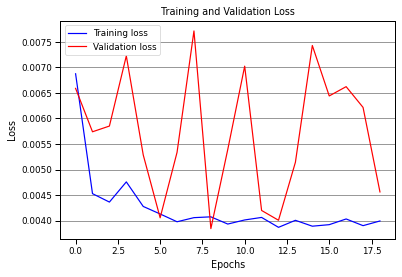

In [29]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    sns.set_context("paper")
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.ticklabel_format(useOffset=False) 
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(axis = "y", color = "0.5")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

***

El error cometido parece bastante bajo. Sin embargo, si calculamos el pseudo $R^{2}$ nos sale un valor de $0.3618$, cosa que es bastante mejorable. Sería necesario comparar el modelo con otros modelos y además realizar un tuneado de hiperparámetros (weights iniciales, learning rate, dropout rate, cantidad de steps...) para mejorar el resutado.

***

In [10]:
score = modelo_vol.evaluate(X_test, y_test, batch_size=8)
print("El MSE cometido en la muestra de test es: " + str(score[0]))

46/46 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
El MSE cometido en la muestra de test es: 0.003643381642177701


In [12]:
from sklearn.metrics import r2_score

y_pred = modelo_vol.predict(X_test, batch_size=1)
print("El pseudo R2 obtenido es: "+ str(round(r2_score(y_test, y_pred),4)))

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print('Test MSE: %.6f' % mse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.6f' % mae)

363/363 [==============================] - 2s 7ms/step
El pseudo R2 obtenido es: 0.2589
Test MSE: 0.003643
Test MAE: 0.045156


***

Como se puede observar en el gráfico de valores predichos frente a los reales, el modelo no se ajusta demasiado bien a los datos. Una sospecha del por qué pasa esto es sobre la función de activación. En futuros modelos se necesitará tunear las funciones para encontrar las que se adapten de la mejor forma.

***

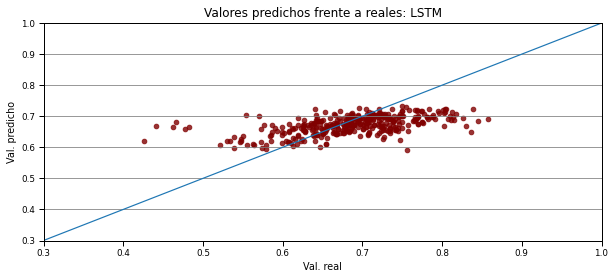

In [13]:
y_actual = y_test.reshape(y_test.shape[0],1)
y_pred2 = y_pred.reshape(y_test.shape[0],1)

data_pred = np.column_stack([y_actual,y_pred2])
data_pred = pd.DataFrame(data_pred, columns = ("true value", "pred value"))

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))

plt.scatter(data_pred["true value"],data_pred["pred value"], c= "maroon", alpha=0.8)

plt.axline([0, 0], slope=1)
plt.xlim(0.3, 1) 
plt.ylim(0.3, 1) 
plt.title("Valores predichos frente a reales: LSTM", fontsize = 12)
plt.xlabel("Val. real")
plt.ylabel("Val. predicho")
plt.grid(axis = "y", color = "0.5")
plt.show()

***

El algoritmo parece predecir relativamente bien la dirección de la volatilidad, pero no se ajusta del todo bien. 

***

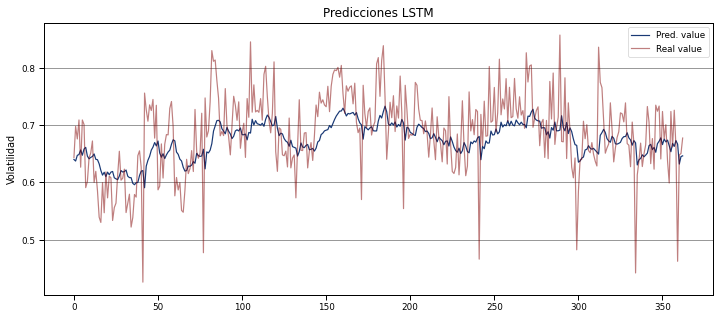

In [14]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (12,5))


#plt.scatter(x = range(0,len(predictions)), y = predictions, color='#002366', alpha = 1)
plt.plot(range(0,len(data_pred["pred value"])), data_pred["pred value"], alpha = 0.9, color = '#002366', label = "Pred. value")

#plt.scatter(x = range(0,len(predictions)), y = test, color='maroon', alpha = 1)
plt.plot(range(0,len(data_pred["pred value"])), data_pred["true value"], alpha = 0.5, color = 'maroon', label = "Real value")

plt.legend()
plt.ticklabel_format(useOffset=False) 
plt.title("Predicciones LSTM", fontsize = 12)
plt.ylabel("Volatilidad")
#plt.xlabel("Iteraciones")
plt.grid(axis = "y", color = "0.5")
plt.show()

# Referecias consultadas 

## Referencias antiguas
- [Asset Return Prediction via Machine Learning](https://www.scirp.org/journal/paperinformation.aspx?paperid=96082)
- [Artificial Neural Networks for Realized Volatility Prediction in Cryptocurrency Time Series](https://link.springer.com/chapter/10.1007/978-3-030-22796-8_18)
- [Machine learning portfolio allocation](https://www.sciencedirect.com/science/article/pii/S2405918821000155?via%3Dihub)
- [Literature review: Machine learning techniques applied to financial market prediction](https://www.sciencedirect.com/science/article/pii/S095741741930017X?via%3Dihub)
- [Neural Network–Based Financial Volatility Forecasting: A Systematic Review](https://dl.acm.org/doi/10.1145/3483596)

## Nuevas Referencias consultadas
- [Predicting stock market index using LSTM](https://www.sciencedirect.com/science/article/pii/S2666827022000378)
- [Research of Stock Price Prediction Based on PCA-LSTM Model](https://iopscience.iop.org/article/10.1088/1757-899X/790/1/012109/pdf)

## Blogs que me han ayudado
- [LSTM Networks | A Detailed Explanation](https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9)
- [Four ways to quantify synchrony between time series data](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)
- [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
- [A Gentle Introduction to LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/)
- [How to Reshape Input Data for Long Short-Term Memory Networks in Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)


***

# GRU

In [15]:
from tensorflow.keras.layers import GRU

90
180
181
100
170
171
110
160
161
120
150
151
130
140
141
140
130
131
150
120
121
160
110
111
170
100
101
180
90
91
190
80
81
200
70
71
210
60
61
220
50
51
230
40
41
240
30
31
250
20
21


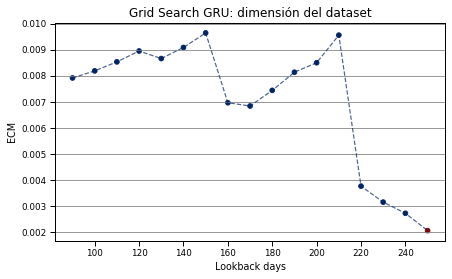

La configuración óptima es:  [250]


In [12]:
def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)

past_size = range(90,260,10)


n = len(train)
score_gru = []
cvset = [0.5, 0.85]


for val in past_size : 
    score = 0
    print(val)
    for cv in cvset : 
        tf.keras.utils.set_random_seed(5)
        
        tf.random.set_seed(10)  
        np.random.seed(10)
        
        data_temp = train[0:int(n*(cv+0.15))]
        Xt_data, yt_data = create_dataset(data_temp, val)
        
        Xt_val = Xt_data[-int(n*(cv+0.15)):-int(n*cv),:]
        yt_val = yt_data[-int(n*(cv+0.15)):-int(n*cv)]
        print(len(yt_val))
        
        train_temp = train[0:int(n*cv)]
        Xt_train, yt_train = create_dataset(train_temp, val)
        
        Xt_train = Xt_train.reshape(Xt_train.shape[0],Xt_train.shape[1] , 1)
        Xt_val = Xt_val.reshape(Xt_val.shape[0],Xt_val.shape[1] , 1)

        modgru_temp = Sequential()
        modgru_temp.add(GRU(128,activation="tanh", input_shape=(Xt_train.shape[1], Xt_train.shape[2])))
        modgru_temp.add(Dense(1, activation = "relu"))

        modgru_temp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tf.keras.metrics.MeanSquaredError())

        modgru_temp.fit(
                Xt_train,
                yt_train,
                epochs = 5,
                validation_data=(Xt_val, yt_val),
                batch_size=32,
                verbose = 0)
        score_temp = modgru_temp.evaluate(Xt_val, yt_val, batch_size=32, verbose = 0)
        score += float(score_temp[0])
    score_gru.append(round(score/len(cvset),6))
'''
score_grid = [0.344034,
 0.34453,
 0.344974,
 0.344554,
 0.343734,
 0.342811,
 0.342522,
 0.341583,
 0.34308,
 0.343174,
 0.345191,
 0.349884,
 0.349106,
 0.367938,
 0.380801,
 0.366448,
 0.378277]
'''

zmin = np.min(score_gru)
mask = np.array(score_gru) == zmin
color = np.where(mask, 'maroon', '#002366')

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (7,4))
plt.scatter(x = past_size, y = score_gru, color=color, alpha = 1)
plt.plot(past_size, score_gru, alpha = 0.7, color = '#002366', linestyle = "--")
plt.ticklabel_format(useOffset=False) 

plt.title("Grid Search GRU: dimensión del dataset", fontsize = 12)
plt.ylabel("ECM")
plt.xlabel("Lookback days")
plt.grid(axis = "y", color = "0.5")
plt.show()
print("La configuración óptima es: ", np.array(past_size)[np.array(score_gru) == zmin])

In [17]:
#Crear los datasets con óptima configuración

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 250

X_train, y_train = create_dataset(train, time_step)
X_data, y_data = create_dataset(data, time_step)

ntest = int(len(X_data)*0.15)

X_test = X_data[-ntest:,:]
y_test = y_data[-ntest:]

X_val = X_data[-(ntest*2):-ntest,:]
y_val = y_data[-(ntest*2):-ntest]

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
import kerastuner as kt

#tf.keras.utils.set_random_seed(100)
#tf.random.set_seed(5)  
#np.random.seed(5)

def build_model_gru(hp):
   # tf.keras.utils.set_random_seed(100)
    hidden_act = hp.Choice('hidden', values=["relu","swish","sigmoid", "tanh", "elu", "linear"])
    output_act = hp.Choice('output', values=["relu", "swish","elu", "linear"])

    units = hp.Int('units', min_value=16, max_value=256, step=16)
    droprate = hp.Int('droprate', min_value=5, max_value=20, step=5)
    recur_drop = hp.Int('recur_drop', min_value=5, max_value=20, step=5)

    drop_fl = droprate/100
    recur_fl = recur_drop/100

    mod_temp = Sequential()
    mod_temp.add(GRU(units, dropout=drop_fl, recurrent_dropout=recur_fl ,activation=hidden_act, input_shape=(X_train.shape[1], X_train.shape[2])))
    mod_temp.add(Dense(1, activation = output_act))

    hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    mod_temp.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=tf.keras.metrics.MeanSquaredError())

    return mod_temp

# HyperBand algorithm from keras tuner
tuner_gru = kt.Hyperband(
    build_model_gru,
    objective='val_loss',
    max_epochs=30,
    directory=r'C:~UC3M\TFG\keras_tuner_GRU',
    project_name='keras_tuner_GRU',
    seed = 1)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_gru.search_space_summary(extended=True)
tuner_gru.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

models = tuner_gru.get_best_models(num_models=1)
gru_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
gru_model.build()
gru_model.summary(expand_nested=True,
    show_trainable=True)


Trial 90 Complete [00h 09m 17s]
val_loss: 0.004704151768237352

Best val_loss So Far: 0.0040498762391507626
Total elapsed time: 02h 12m 39s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 gru (GRU)                   (None, 16)                912       Y          
                                                                            
 dense (Dense)               (None, 1)                 17        Y          
                                                                            
Total params: 929
Trainable params: 929
Non-trainable params: 0
____________________________________________________________________________


In [19]:
best_hps_gru = tuner_gru.get_best_hyperparameters()[0]
print(best_hps_gru.values)

{'hidden': 'tanh', 'output': 'swish', 'units': 16, 'droprate': 10, 'recur_drop': 10, 'lr': 0.002029157951106482, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [20]:
gru_model.save(r'C:~UC3M\TFG\Modelos\GRU_model1.h5')

In [16]:
modelo_vol_gru = keras.models.load_model(r'C:~TFG\Modelos\GRU_model1.h5')

In [56]:
path_checkpoint = r'C:~TFG\Modelos\GRU_model1_trained.h5'
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
    restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)    

tf.keras.utils.set_random_seed(123)
tf.random.set_seed(2)  
np.random.seed(2)

history_gru = modelo_vol_gru.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data= (X_val, y_val),
    callbacks=[modelckpt_callback, es_callback],
    batch_size=8)

Epoch 1/50
206/206 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 1: val_loss improved from inf to 0.00401, saving model to C:\Users\super\OneDrive\Documentos\UC3M\TFG\Modelos\GRU_model1_trained.h5
206/206 [==============================] - 38s 179ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/50
206/206 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 2: val_loss improved from 0.00401 to 0.00386, saving model to C:\Users\super\OneDrive\Documentos\UC3M\TFG\Modelos\GRU_model1_trained.h5
206/206 [==============================] - 35s 172ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/50
206/206 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 3: val_loss improved from 0.00386 to 0.00384, saving model to C:\Users\super\OneDrive\Do

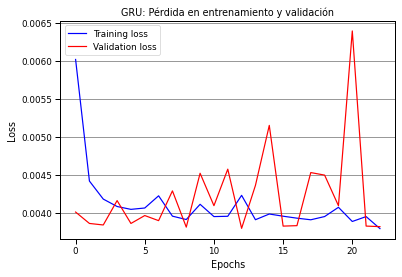

In [58]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    sns.set_context("paper")
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.ticklabel_format(useOffset=False) 
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(axis = "y", color = "0.5")
    plt.legend()
    plt.show()

visualize_loss(history_gru, "GRU: Pérdida en entrenamiento y validación")

In [18]:
score = modelo_vol_gru.evaluate(X_test, y_test, batch_size=8)
print("GRU: El MSE cometido en la muestra de test es: " + str(score[0]))

44/44 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
GRU: El MSE cometido en la muestra de test es: 0.0037998026236891747


In [20]:
from sklearn.metrics import r2_score

y_pred = modelo_vol_gru.predict(X_test, batch_size=1)
print("GRU: El pseudo R2 obtenido es: "+ str(round(r2_score(y_test, y_pred),4)))

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print('Test MSE: %.6f' % mse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.6f' % mae)

349/349 [==============================] - 4s 12ms/step
GRU: El pseudo R2 obtenido es: 0.2402
Test MSE: 0.003800
Test MAE: 0.046197


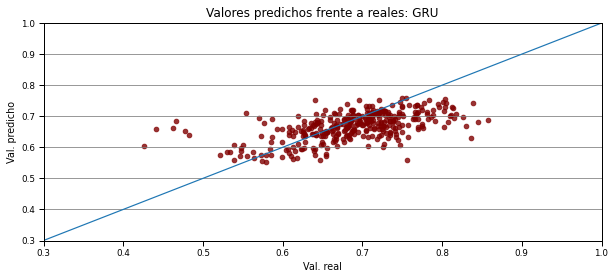

In [21]:
y_actual = y_test.reshape(y_test.shape[0],1)
y_pred2 = y_pred.reshape(y_test.shape[0],1)

data_pred = np.column_stack([y_actual,y_pred2])
data_pred = pd.DataFrame(data_pred, columns = ("true value", "pred value"))

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,4))

plt.scatter(data_pred["true value"],data_pred["pred value"], c= "maroon", alpha=0.8)

plt.axline([0, 0], slope=1)
plt.xlim(0.3, 1) 
plt.ylim(0.3, 1) 
plt.title("Valores predichos frente a reales: GRU", fontsize = 12)
plt.xlabel("Val. real")
plt.ylabel("Val. predicho")
plt.grid(axis = "y", color = "0.5")
plt.show()

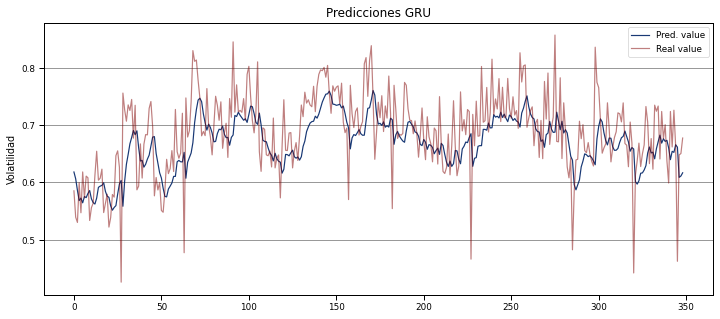

In [22]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (12,5))


#plt.scatter(x = range(0,len(predictions)), y = predictions, color='#002366', alpha = 1)
plt.plot(range(0,len(data_pred["pred value"])), data_pred["pred value"], alpha = 0.9, color = '#002366', label = "Pred. value")

#plt.scatter(x = range(0,len(predictions)), y = test, color='maroon', alpha = 1)
plt.plot(range(0,len(data_pred["pred value"])), data_pred["true value"], alpha = 0.5, color = 'maroon', label = "Real value")

plt.legend()
plt.ticklabel_format(useOffset=False) 
plt.title("Predicciones GRU", fontsize = 12)
plt.ylabel("Volatilidad")
#plt.xlabel("Iteraciones")
plt.grid(axis = "y", color = "0.5")
plt.show()